# Answering the questions

✔️ Answer the questions below (briefly):

🌈 What is the difference between Character n-gram and Word n-gram? Which one tends to suffer more from the OOV issue?

- The main difference between character n-gram and word n-gram is that character n-gram is based on individual characters, whereas word n-gram is based on whole words
- In terms of the OOV (out-of-vocabulary) issue, character n-gram tends to suffer less than word n-gram. This is because character n-gram can capture sub-word information




🌈 What is the difference between stop word removal and stemming? Are these techniques language-dependent?

- the main difference between the two is that stop word removal involves completely eliminating predetermined words that are listed, while stemming involves reducing words to their roots by removing prefixes and suffixes, without removing the entire word.
- These techniques can be language-dependent as stop words and word inflections can vary across different languages




🌈 Is tokenization techniques language dependent? Why?

- Yes, tokenization techniques are language-dependent, as different languages have their own unique rules and structures for dividing text into individual units or tokens.


🌈 What is the difference between count vectorizer and tf-idf vectorizer? Would it be feasible to use all possible n-grams? If not, how should you select them?

- Count vectorizer is a simple technique that converts a collection of text documents into a matrix of token counts
- TF-IDF (term frequency-inverse document frequency) vectorizer, on the other hand, is a more advanced technique that assigns weights to the words based on their importance in the text
- it may not be feasible to use all possible n-grams as the number of features can become very large, leading to the curse of dimensionality and computational complexity

# Problem Formulation:

##problem definition

- The problem  is about building a model to classify and detect which real news and fake news from just its titles.

- inputs: (60000) observations for a training dataset 
- output is (59151) label.

## Function and Model
Text preprocessing, Tokenization Then Vectorization on Each text

Then Training The Model (Classification)

## Challenges

The Data Has Unclean Text That Contain Huge Number Of Punctuations, Non-English Letters, Misspellings And Grammatical Errors. So it require an appropriate text cleaning technique to be selected.

## Model impact

Prevent The Spreading of Rumors or False News On Social Media. 

## The ideal solution

Using a SVC Classifier with GridSearch to get the best hyperparameters combinations to get better Accuracy result (86.23%)

# Importing Libraries and check data

In [1]:
!pip install scikit-optimize
!pip install xgboost
!pip install nltk
!pip install seaborn

In [2]:
import re
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Loading Data
df = pd.read_csv("xy_train.csv", index_col='id')
test = pd.read_csv('x_test.csv',index_col='id')

In [4]:
df.head()

,text,label
id,,
265723,A group of friends began to volunteer at a hom...,0
284269,British Prime Minister @Theresa_May on Nerve A...,0
207715,"In 1961, Goodyear released a kit that allows P...",0
551106,"Happy Birthday, Bob Barker! The Price Is Right...",0
8584,"Obama to Nation: 聙""Innocent Cops and Unarmed Y...",0


In [5]:
# Check the Shape of the training and test Data
print("Training Date Shape: ", df.shape)
print("Testing Date Shape: ", test.shape)

Training Date Shape:  (60000, 2)
Testing Date Shape:  (59151, 1)


# Part 1: Data Preprocessing

**I Wanted to Use This but was the same as the function Below**

In [6]:
# url = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
# user = '@[^\s]+'
# alpha = "[^a-zA-Z0-9]"

In [7]:
# #Cleaining The Data
# # Drop duplicate rows
# df.drop_duplicates(subset='text', inplace=True)
# # Remove numbers 
# df['text'] = df['text'].str.replace('[^A-Za-z]',' ')
# # Make sure any double-spaces are single 
# df['text'] = df['text'].str.replace('  ',' ')
# # Transform all text to lowercase
# df['text'] = df['text'].str.lower()


# df['text'] = df['text'].str.replace("don't", "do not")
# df['text'] = df['text'].str.replace("won't", "will not")
# df['text'] = df['text'].str.replace("'re", " are")
# df['text'] = df['text'].str.replace("i'm", "i am")
# df['text'] = df['text'].str.replace("'m", " am")
# df['text'] = df['text'].str.replace("let's", "let us")
# df['text'] = df['text'].str.replace("'s", " is")
# df['text'] = df['text'].str.replace("'ve", " have")
# df['text'] = df['text'].str.replace("can't", "can not")
# df['text'] = df['text'].str.replace("shan't", "shall not")
# df['text'] = df['text'].str.replace("n't", " not")
# df['text'] = df['text'].str.replace("'d", " would")
# df['text'] = df['text'].str.replace("'ll", " will")
# df['text'] = df['text'].str.replace(url, "URL")
# df['text'] = df['text'].str.replace(user, " ")
# df['text'] = df['text'].str.replace(alpha, " ")
# df['text'] = df['text'].str.strip()

In [8]:
# Checking The Label Class
df["label"].value_counts(normalize=True)
# We can see that there are Label 2

0    0.536200
1    0.459933
2    0.003867
Name: label, dtype: float64

In [9]:
# We drop the ones that Contain Label 2
df.drop(df[df.label == 2].index, inplace = True)

<AxesSubplot:xlabel='label', ylabel='count'>

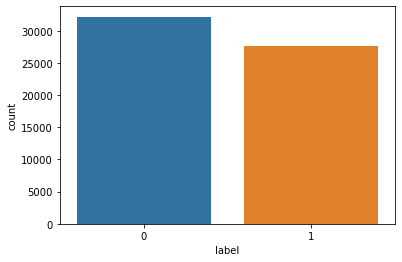

In [10]:
# We Can See that the data is Good now
sns.countplot(x="label", data=df)

In [11]:
df["label"].value_counts(normalize=True)

0    0.538281
1    0.461719
Name: label, dtype: float64

## Cleaning The Text

**We Will Clean The Data and use Lemmatization and Stemming**

In [12]:
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
stemmer = SnowballStemmer("english")
stop_words = set(stopwords.words("english"))
print(stop_words)

def cleaning_text(text, for_embedding):
    """
        - remove any html tags (< /br> often found)
        - Keep only ASCII + European Chars and whitespace, no digits
        - remove single letter chars
        - convert all whitespaces (tabs etc.) to single wspace

    """
    #match one or more white sepace
    RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
    #match <any num of words>
    RE_TAGS = re.compile(r"<.*?>")
    #match any English word
    RE_ASCII = re.compile(r"[^A-Za-zÀ-ž0-9]+", re.IGNORECASE)
    #match any word with word boundary.
    RE_SINGLECHAR = re.compile(r"\b^[^A-Za-zÀ-ž0-9]+\b", re.IGNORECASE)
    
    if for_embedding:
        # Keep punctuation
        
        #match any English word and any punctuation
        RE_ASCII = re.compile(r"[^A-Za-zÀ-ž,.!? ]", re.IGNORECASE)
        #match any word and any punctuation with word boundary.
        RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž,.!?]\b", re.IGNORECASE)

    #remove one or more white sepace
    text = re.sub(RE_TAGS, " ", text) 
    #remove <any num of words>
    text = re.sub(RE_ASCII, " ", text) 
    #remove any English word
    text = re.sub(RE_SINGLECHAR, " ", text)
    #remove any word with word boundary.
    text = re.sub(RE_WSPACE, " ", text)
    word_tokens = word_tokenize(text)
    
    return word_tokens

def lemmatize_clean_text(text ,for_embedding=False):

    """ steps:
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and lemmatize
    """

    lemmatizer = WordNetLemmatizer()

    word_tokens = cleaning_text(text, for_embedding)

    if for_embedding:
        # no stemming or lemmatization, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_tokens_lower = [word.lower() for word in word_tokens]
        words_filtered = [lemmatizer.lemmatize(word) for word in words_tokens_lower if word not in stop_words]

    clean_text = " ".join(words_filtered)
    return clean_text



def stemming_clean_text(text ,for_embedding=False):
    """ steps:
        if not for embedding (but e.g. tdf-idf):
        - all lowercase
        - remove stopwords, punctuation and stemming
    """

    word_tokens = cleaning_text(text,for_embedding)

    if for_embedding:
        # no stemming or lemmatization, lowering and punctuation / stop words removal
        words_filtered = word_tokens
    else:
        words_tokens_lower = [word.lower() for word in word_tokens]
        words_filtered = [stemmer.stem(word) for word in words_tokens_lower if word not in stop_words]

    clean_text = " ".join(words_filtered)
    return clean_text

{'needn', 's', "you've", 'ain', 'did', 'to', 'shouldn', 'had', "you'd", 'too', 'be', 'can', "hadn't", 'ma', "don't", 'nor', 'does', 'ourselves', 'am', 'down', "aren't", 'by', "won't", 'such', 'haven', 'not', 'won', 'just', 'them', 'it', 'but', 'of', 'having', 'i', 'me', 'my', 'isn', 'mightn', 'herself', 't', 'at', "shan't", 'you', 'are', 'under', 'once', 'will', 'himself', 'o', 'weren', 'y', 'myself', 'then', 'doesn', 'hasn', "mustn't", 'out', 'wouldn', 'few', 'themselves', 'only', 'both', "couldn't", 'so', 'on', 'up', 'why', 'don', 'were', 'and', 'with', 'should', "mightn't", 'his', 'which', 'she', 'above', 'here', 'very', "hasn't", 'through', 'been', 'yours', 'some', "she's", "should've", 'now', 'how', 'who', 'off', 'when', 'while', 'below', 'yourselves', 'ours', 'hers', "that'll", 'll', 'm', 'from', 've', 'is', 'same', 'because', 'most', 'her', 'any', 'aren', 'do', 'being', "shouldn't", 'own', 'theirs', 'against', "doesn't", 'your', 'couldn', 'itself', 'again', 'for', 'about', 'each

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DeKaiTo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\DeKaiTo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DeKaiTo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\DeKaiTo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [13]:
# Data Before Applying the Function
df["text"]

id
265723    A group of friends began to volunteer at a hom...
284269    British Prime Minister @Theresa_May on Nerve A...
207715    In 1961, Goodyear released a kit that allows P...
551106    Happy Birthday, Bob Barker! The Price Is Right...
8584      Obama to Nation: 聙"Innocent Cops and Unarmed Y...
                                ...                        
70046     Finish Sniper Simo H盲yh盲 during the invasion o...
189377    Nigerian Prince Scam took $110K from Kansas ma...
93486     Is It Safe To Smoke Marijuana During Pregnancy...
140950    Julius Caesar upon realizing that everyone in ...
34509     Jeff Bridges Releasing 鈥楽leeping Tapes,鈥?a New...
Name: text, Length: 59768, dtype: object

In [14]:
# Applying the Function for both Test and Training Dataset
df_lemmatized = df["text"].map(lambda x: lemmatize_clean_text(x ,for_embedding=False) if isinstance(x, str) else x).copy() ## clean and lemmatiz training set
df_stemmed = df["text"].map(lambda x: stemming_clean_text(x, for_embedding=False) if isinstance(x, str) else x).copy() ## word cleaning and stemming training set
test_lemmatized = test["text"].map(lambda x: lemmatize_clean_text(x ,for_embedding=False) if isinstance(x, str) else x).copy() ## word cleaning and lemmatizing test set
test_stemmed = test["text"].map(lambda x: stemming_clean_text(x ,for_embedding=False) if isinstance(x, str) else x).copy() ## word cleaning and lemmatizing test set

In [15]:
# Data After Applying the Function
df_lemmatized

id
265723    group friend began volunteer homeless shelter ...
284269    british prime minister theresa may nerve attac...
207715    1961 goodyear released kit allows ps2s brought...
551106    happy birthday bob barker price right host lik...
8584      obama nation innocent cop unarmed young black ...
                                ...                        
70046     finish sniper simo h yh invasion finland ussr ...
189377    nigerian prince scam took 110k kansa man 10 ye...
93486       safe smoke marijuana pregnancy surprised answer
140950    julius caesar upon realizing everyone room kni...
34509     jeff bridge releasing leeping tape new album d...
Name: text, Length: 59768, dtype: object

In [16]:
# Checking the Stem Also
df_stemmed

id
265723    group friend began volunt homeless shelter nei...
284269    british prime minist theresa may nerv attack f...
207715    1961 goodyear releas kit allow ps2s brought he...
551106    happi birthday bob barker price right host lik...
8584      obama nation innoc cop unarm young black men d...
                                ...                        
70046     finish sniper simo h yh invas finland ussr 193...
189377    nigerian princ scam took 110k kansa man 10 yea...
93486          safe smoke marijuana pregnanc surpris answer
140950    julius caesar upon realiz everyon room knife e...
34509     jeff bridg releas leep tape new album design h...
Name: text, Length: 59768, dtype: object

In [17]:
# Word Frequency of most common words in Traing data After lemmatization
word_freq_lemmatized = pd.Series(" ".join(df_lemmatized).split()).value_counts()
word_freq_lemmatized[0:10]

0            4307
year         4121
one          3285
new          2998
like         2949
man          2705
trump        2577
u            2513
colorized    2430
people       2315
dtype: int64

In [18]:
# Word Frequency of most common words in in Traing data After Stemming
word_freq_stemmed = pd.Series(" ".join(df_stemmed).split()).value_counts()
word_freq_stemmed[0:10]

0        4293
year     4125
one      3285
like     3128
new      2998
look     2847
color    2737
man      2728
get      2602
trump    2578
dtype: int64

# Part 2: Building The Models

## A Tunable Pipeline

In [19]:
# feature creation and modelling

pipe_lg = Pipeline(
    [
        ("tfidf", TfidfVectorizer()), 
        ("lg", LogisticRegression(max_iter=10000, random_state = 44, n_jobs=-1))
    ]
)

pipe_xgb = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("xgb", XGBClassifier(random_state=44, n_jobs=-1))
    ]
)

pipe_svc = Pipeline(
    [
        ("tfidf", TfidfVectorizer()),
        ("svc", SVC(random_state=44, probability=True))
    ]
)

## Here I Will Do 5 Trials,

**Using 3 Models Which Are Logistic Regression, XGBoost And SVM.**


**Each Model I Will Use Stemmed Data And another Trial I Will Use Lemmatized Data Except For SVM will only Use Stemmed Because The Long Time it takes toy train the SVM Model**

## Logistic Regression

### Trial 1: Using Stemmed Data

In [20]:
# Define parameters To Use
params = {
    'tfidf__sublinear_tf':[True],
    'tfidf__strip_accents':[None],
    'tfidf__smooth_idf':[True],
    'tfidf__ngram_range': [(1, 4)],
    'tfidf__analyzer':['word'],
    'tfidf__min_df': [6], 
    'tfidf__max_df': [0.2],
    'lg__class_weight':['balanced',None],
    "lg__solver" : ['sag','newton-cg', 'lbfgs','liblinear','saga'],
    'lg__C': [1.5,2.0,3.5],
    'lg__fit_intercept':[False, True]

}


# Here we Will use The Stemmed Data
pipe_lg_clf = RandomizedSearchCV(pipe_lg, params, n_jobs=-1,cv=2, scoring="roc_auc", n_iter=200, verbose=1)
pipe_lg_clf.fit(df_stemmed, df['label'])

Fitting 2 folds for each of 60 candidates, totalling 120 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('lg',
                                              LogisticRegression(max_iter=10000,
                                                                 n_jobs=-1,
                                                                 random_state=44))]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'lg__C': [1.5, 2.0, 3.5],
                                        'lg__class_weight': ['balanced', None],
                                        'lg__fit_intercept': [False, True],
                                        'lg__solver': ['sag', 'newton-cg',
                                                       'lbfgs', 'liblinear',
                                                       'saga'],
                                        'tfidf__analyzer': ['word'],
                                        'tfidf__max_df':

In [21]:
print('best score {}'.format(pipe_lg_clf.best_score_))
print('best params {}'.format(pipe_lg_clf.best_params_))

best score 0.8608721069334946
best params {'tfidf__sublinear_tf': True, 'tfidf__strip_accents': None, 'tfidf__smooth_idf': True, 'tfidf__ngram_range': (1, 4), 'tfidf__min_df': 6, 'tfidf__max_df': 0.2, 'tfidf__analyzer': 'word', 'lg__solver': 'newton-cg', 'lg__fit_intercept': False, 'lg__class_weight': 'balanced', 'lg__C': 2.0}


In [22]:
#create submission file
submission = pd.DataFrame()
submission['id'] = test_stemmed.index
submission['label'] = pipe_lg_clf.predict_proba(test_stemmed)[:,1]
submission.to_csv('lg_stem.csv', index=False)

### Trial 2: Using Lemmatized Data And GridSearch

In [23]:
# Define parameters To Use
params = {
    'tfidf__sublinear_tf':[False],
    'tfidf__strip_accents':["unicode"],
    'tfidf__smooth_idf':[False],
    'tfidf__ngram_range': [(1, 4)],
    'tfidf__analyzer':['word'],
    'tfidf__min_df': [5], 
    'tfidf__max_df': [0.2],
    'lg__class_weight':['balanced',None],
    "lg__solver" : ['sag','newton-cg', 'lbfgs','liblinear','saga', 'sag'],
    'lg__C': [1.5,2.0,3.5],
    'lg__fit_intercept':[False, True],

}

# Here we Will use The Lemmetized Data
pipe_lg_clf2 = GridSearchCV(pipe_lg, params, n_jobs=-1,cv=2, scoring="roc_auc", verbose=1)
pipe_lg_clf2.fit(df_lemmatized, df['label'])

Fitting 2 folds for each of 72 candidates, totalling 144 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('lg',
                                        LogisticRegression(max_iter=10000,
                                                           n_jobs=-1,
                                                           random_state=44))]),
             n_jobs=-1,
             param_grid={'lg__C': [1.5, 2.0, 3.5],
                         'lg__class_weight': ['balanced', None],
                         'lg__fit_intercept': [False, True],
                         'lg__solver': ['sag', 'newton-cg', 'lbfgs',
                                        'liblinear', 'saga', 'sag'],
                         'tfidf__analyzer': ['word'], 'tfidf__max_df': [0.2],
                         'tfidf__min_df': [5], 'tfidf__ngram_range': [(1, 4)],
                         'tfidf__smooth_idf': [False],
                         'tfidf__strip_accents': ['unicode'],
                         'tf

In [24]:
print('best score {}'.format(pipe_lg_clf2.best_score_))
print('best params {}'.format(pipe_lg_clf2.best_params_))

best score 0.8628684361111858
best params {'lg__C': 2.0, 'lg__class_weight': 'balanced', 'lg__fit_intercept': False, 'lg__solver': 'liblinear', 'tfidf__analyzer': 'word', 'tfidf__max_df': 0.2, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 4), 'tfidf__smooth_idf': False, 'tfidf__strip_accents': 'unicode', 'tfidf__sublinear_tf': False}


In [25]:
#create submission file
submission = pd.DataFrame()
submission['id'] = test_lemmatized.index
submission['label'] = pipe_lg_clf2.predict_proba(test_lemmatized)[:,1]
submission.to_csv('lg_lemmatized.csv', index=False)

## XGBoost

### Trial 3: Using Stemmed Data

In [26]:
# Define parameters To Use
params = {
    'tfidf__sublinear_tf':[False], 
    'tfidf__strip_accents':['unicode'],
    'tfidf__smooth_idf':[False],
    'tfidf__ngram_range': [(1, 5)],
    'tfidf__min_df': [6], 
    'tfidf__max_df': [0.2],
    'tfidf__analyzer':['char'],
    'xgb__booster':['dart'],
    'xgb__n_estimators': [450, 500],
    'xgb__max_depth': [60, 65],
    'xgb__learning_rate': [0.1],
    'xgb__gamma': [0.1],
    'xgb__subsample': [0.8]

}

# Here we Will use The Stemmed Data
pipe_xgb_clf = RandomizedSearchCV(pipe_xgb, params, n_jobs=-1,cv=2, scoring="roc_auc", n_iter=10, verbose=1)
pipe_xgb_clf.fit(df_stemmed, df['label'])

Fitting 2 folds for each of 4 candidates, totalling 8 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                      

In [27]:
print('best score {}'.format(pipe_xgb_clf.best_score_))
print('best score {}'.format(pipe_xgb_clf.best_params_))

best score 0.8495079273589194
best score {'xgb__subsample': 0.8, 'xgb__n_estimators': 450, 'xgb__max_depth': 65, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__booster': 'dart', 'tfidf__sublinear_tf': False, 'tfidf__strip_accents': 'unicode', 'tfidf__smooth_idf': False, 'tfidf__ngram_range': (1, 5), 'tfidf__min_df': 6, 'tfidf__max_df': 0.2, 'tfidf__analyzer': 'char'}


In [28]:
#create submission file
submission = pd.DataFrame()
submission['id'] = test_stemmed.index
submission['label'] = pipe_xgb_clf.predict_proba(test_stemmed)[:,1]
submission.to_csv('xgb_stem.csv', index=False)

### Trial 4: Using Lemmatized Data

In [29]:
# Define parameters To Use
params = {
    'tfidf__sublinear_tf':[False], 
    'tfidf__strip_accents':['unicode'],
    'tfidf__smooth_idf':[False],
    'tfidf__ngram_range': [(1, 5)],
    'tfidf__min_df': [6], 
    'tfidf__max_df': [0.2],
    'tfidf__analyzer':['char'],
    'xgb__booster':['gbtree','gblinear', 'dart'],
    'xgb__n_estimators': [450, 500],
    'xgb__max_depth': [60, 70],
    'xgb__learning_rate': [0.1],
    'xgb__gamma': [0.1],
    'xgb__subsample': [0.8]

}

# Here we Will use The Lemmatized Data
pipe_xgb_clf2 = RandomizedSearchCV(pipe_xgb, params, n_jobs=-1,cv=2, scoring="roc_auc", n_iter=10, verbose=1)
pipe_xgb_clf2.fit(df_lemmatized, df['label'])

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                             ('xgb',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            early_stopping_rounds=None,
                                                            enable_categorical=False,
                                                            eval_metric=None,
                                                            feature_types=None,
                                      

In [30]:
print('best score {}'.format(pipe_xgb_clf2.best_score_))
print('best params {}'.format(pipe_xgb_clf2.best_params_))

best score 0.8508863791297021
best params {'xgb__subsample': 0.8, 'xgb__n_estimators': 450, 'xgb__max_depth': 60, 'xgb__learning_rate': 0.1, 'xgb__gamma': 0.1, 'xgb__booster': 'dart', 'tfidf__sublinear_tf': False, 'tfidf__strip_accents': 'unicode', 'tfidf__smooth_idf': False, 'tfidf__ngram_range': (1, 5), 'tfidf__min_df': 6, 'tfidf__max_df': 0.2, 'tfidf__analyzer': 'char'}


In [31]:
#create submission file
submission = pd.DataFrame()
submission['id'] = test_stemmed.index
submission['label'] = pipe_xgb_clf2.predict_proba(test_lemmatized)[:,1]
submission.to_csv('xgb_lem.csv', index=False)

## Support Vector Machine

### Trial 5: Using Stemmed Data

In [32]:
# define parameter space to test
params = {
    'tfidf__sublinear_tf':[True], 
    'tfidf__strip_accents':['unicode'],
    'tfidf__smooth_idf':[False],
    'tfidf__ngram_range': [(1, 2)],
    'tfidf__min_df': [5], 
    'tfidf__max_df': [0.2],
    'tfidf__analyzer':['word']
}

# Here we Will use The Stemmed Data
pipe_svc_clf = GridSearchCV(pipe_svc, params, n_jobs=-1,cv=2, scoring="roc_auc", verbose=1)
pipe_svc_clf.fit(df_stemmed, df['label'])

Fitting 2 folds for each of 1 candidates, totalling 2 fits


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svc',
                                        SVC(probability=True,
                                            random_state=44))]),
             n_jobs=-1,
             param_grid={'tfidf__analyzer': ['word'], 'tfidf__max_df': [0.2],
                         'tfidf__min_df': [5], 'tfidf__ngram_range': [(1, 2)],
                         'tfidf__smooth_idf': [False],
                         'tfidf__strip_accents': ['unicode'],
                         'tfidf__sublinear_tf': [True]},
             scoring='roc_auc', verbose=1)

In [33]:
print('best score {}'.format(pipe_svc_clf.best_score_))
print('best score {}'.format(pipe_svc_clf.best_params_))

best score 0.8623373241850132
best score {'tfidf__analyzer': 'word', 'tfidf__max_df': 0.2, 'tfidf__min_df': 5, 'tfidf__ngram_range': (1, 2), 'tfidf__smooth_idf': False, 'tfidf__strip_accents': 'unicode', 'tfidf__sublinear_tf': True}


In [34]:
#create submission file
submission = pd.DataFrame()
submission['id'] = test_stemmed.index
submission['label'] = pipe_svc_clf.predict_proba(test_stemmed)[:,1]
submission.to_csv('svc_stem.csv', index=False)

# Trials Results

**As we Can see that Lemmatization is Better than Stemmed Data and the Reason is That:**


**Stemming is a crude process that chops off the ends of words, while lemmatization is a more sophisticated process that uses a vocabulary and morphological analysis to find the dictionary form of a word.**

**That aside let's Compare between the models**

**We can See that the Accuracy of Each Model isn't that big but compared to the time taken the XGBoost and SVC took to much time (More that 12 Hours) and this with hust few hyperparameters**

**But For the SVC I Used only a few Hyperprameters and yet the accuracy with better than the other models so If I Did include more Hyperparameters Range I Think it will be even more better But the time will Skyrocket**